In [1]:
import numpy as np
import numpy.ma as ma
import rasterio
import cv2
import tensorflow as tf
import tensorflow.keras.backend as K
import imgaug as ia
import matplotlib.pyplot as plt

from PIL import Image
from glob import glob
from imgaug import augmenters as iaa

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from IPython.display import clear_output
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import (
    EarlyStopping,
    ModelCheckpoint,
)
from tensorflow.keras.layers import (
    Input,
    Dense,
    Conv2D,
    UpSampling2D,
    MaxPooling2D,
    Dropout,
    concatenate,
    Conv2DTranspose,
    BatchNormalization,
    Flatten
)

ia.seed(2)

In [2]:
# configuration variables
input_size = 256
n_channels = 3
model_save_path = 'test_model.h5'

In [3]:
class UnetGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'

    def __init__(self, data_path,
                 to_fit=True, batch_size=1, dim=(256, 256),
                 n_channels=3, shuffle=True, augment=True):
        'Initialization'
        self.data_path = data_path
        self.tif_list = []
        self.mask_list = []
        for filename in glob(f'{data_path}*.tif*'):
            self.tif_list.append(filename)

        self.to_fit = to_fit
        self.augment = augment
        self.batch_size = batch_size
        self.dim = dim
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.n = 0
        self.max = self.__len__()
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.tif_list) / self.batch_size))

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.tif_list))
        if self.shuffle is True:
            np.random.shuffle(self.indexes)

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index *
                               self.batch_size: (index + 1) * self.batch_size]

        # Find list of IDs
        tif_list_temp = [self.tif_list[k] for k in indexes]

        # Generate data
        X = self._generate_X(tif_list_temp)

        #  preprocess and augment data

        if self.to_fit:
            y = self._generate_y(tif_list_temp)

            if self.augment:
                seq = make_augmentations()
                images_aug = list()
                labels_aug = list()
                for i in range(len(X)):
                    image, label = seq(
                        image=X[i].astype('float32'),
                        segmentation_maps=np.expand_dims(
                            y[i], 0).astype('uint8')
                    )
                    images_aug.append(image)
                    labels_aug.append(label[0, :, :, :])

                return np.array(images_aug), np.array(labels_aug)
            else:
                # import ipdb; ipdb.set_trace()
                return X, y[:,:,:,0]

        else:
            return X

    def _generate_X(self, tif_list_temp):
        'Generates data containing batch_size images'
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))

        # Generate data
        for i, ID in enumerate(tif_list_temp):
            # Store sample
            X[i, ] = _load_tif_image(ID, self.dim)

        return X

    def _generate_y(self, tif_list_temp):
        'Generates data containing batch_size masks'
        y = np.empty((self.batch_size, *self.dim, 1), dtype='float32')

        # Generate data
        for i, ID in enumerate(tif_list_temp):
            # replace tif/tiff with the _bitmap.png or .bmp, depending on the dataset
            # to look for corresponding masks for the imput images
            y[i, ] = _load_grayscale_image(ID.replace(
                '.tiff', '_bitmap.png'), self.dim
            )

        return y

    def __next__(self):
        if self.n >= self.max:
            self.n = 0
        result = self.__getitem__(self.n)
        self.n += 1
        return result


def _load_grayscale_image(image_path, dim):
    'Load grayscale image'
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = img / 255

    return np.expand_dims(cv2.resize(img, dim), -1)


def _load_tif_image(image_path, dim):
    'load tif image'

    with rasterio.open(image_path, 'r') as data:
        return cv2.resize(
            np.moveaxis(data.read(), 0, -1), dim
        )


def sometimes(aug):
    return iaa.Sometimes(0.5, aug)

def make_augmentations():

    return iaa.Sequential([
        sometimes(iaa.CoarseDropout(0.1, size_percent=0.2)),
        sometimes(
            iaa.Affine(
                scale={"x": (0.9, 1.1), "y": (0.9, 1.1)},
                # scale images to 80-120% of their size,
                # individually per axis
                translate_percent={
                    "x": (-0.1, 0.1), "y": (-0.1, 0.1)},
                # translate by -20 to +20 percent (per axis)
                # rotate by -45 to +45 degrees
                rotate=(-10, 10),
                shear=(-5, 5),  # shear by -16 to +16 degrees
            ),
        ),
        sometimes(iaa.ElasticTransformation(alpha=10, sigma=1))
    ],
        random_order=True
    )

In [4]:
num_layers = 2
input_shape = (input_size, input_size, 3)
inputs = Input(input_shape)

def bn_conv_relu(input, filters, bachnorm_momentum, **conv2d_args):
    x = BatchNormalization(momentum=bachnorm_momentum)(input)
    x = Conv2D(filters, **conv2d_args)(x)
    return x


def bn_upconv_relu(input, filters, bachnorm_momentum, **conv2d_trans_args):
    x = BatchNormalization(momentum=bachnorm_momentum)(input)
    x = Conv2DTranspose(filters, **conv2d_trans_args)(x)
    return x

filters = 24
upconv_filters = 32

kernel_size = (3, 3)
activation = 'relu'
strides = (1, 1)
padding = 'same'
kernel_initializer = 'he_normal'
output_activation = 'sigmoid'

conv2d_args = {
    'kernel_size': kernel_size,
    'activation': activation,
    'strides': strides,
    'padding': padding,
    'kernel_initializer': kernel_initializer
}

conv2d_trans_args = {
    'kernel_size': kernel_size,
    'activation': activation,
    'strides': (2, 2),
    'padding': padding,
}

bachnorm_momentum = 0.01

pool_size = (2, 2)
pool_strides = (2, 2)
pool_padding = 'valid'

maxpool2d_args = {
    'pool_size': pool_size,
    'strides': pool_strides,
    'padding': pool_padding,
}

x = Conv2D(filters, **conv2d_args)(inputs)
c1 = bn_conv_relu(x, filters, bachnorm_momentum, **conv2d_args)
x = bn_conv_relu(c1, filters, bachnorm_momentum, **conv2d_args)
x = MaxPooling2D(**maxpool2d_args)(x)

down_layers = []

for l in range(num_layers):
    x = bn_conv_relu(x, filters, bachnorm_momentum, **conv2d_args)
    x = bn_conv_relu(x, filters, bachnorm_momentum, **conv2d_args)
    down_layers.append(x)
    x = bn_conv_relu(x, filters, bachnorm_momentum, **conv2d_args)
    x = MaxPooling2D(**maxpool2d_args)(x)

x = bn_conv_relu(x, filters, bachnorm_momentum, **conv2d_args)
x = bn_conv_relu(x, filters, bachnorm_momentum, **conv2d_args)
x = bn_upconv_relu(x, filters, bachnorm_momentum, **conv2d_trans_args)

for conv in reversed(down_layers):
    x = concatenate([x, conv])
    x = bn_conv_relu(
        x, upconv_filters, bachnorm_momentum, **conv2d_args
    )
    x = bn_conv_relu(x, filters, bachnorm_momentum, **conv2d_args)
    x = bn_upconv_relu(
        x, filters, bachnorm_momentum, **conv2d_trans_args
    )

x = concatenate([x, c1])
x = bn_conv_relu(x, upconv_filters, bachnorm_momentum, **conv2d_args)
x = bn_conv_relu(x, filters, bachnorm_momentum, **conv2d_args)

outputs = Conv2D(
    1,
    kernel_size=(1, 1),
    strides=(1, 1),
    activation=output_activation,
    padding='valid')(x)

model = Model(inputs=[inputs], outputs=[outputs])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 24) 672         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 24) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 24) 5208        batch_normalization[0][0]        
______________________________________________________________________________________________

In [5]:
class PlotLearning(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('accuracy'))
        self.val_acc.append(logs.get('val_accuracy'))
        self.i += 1
        f, (ax1, ax2) = plt.subplots(1, 2, sharex=True)
        
        clear_output(wait=True)
        
        ax1.set_yscale('log')
        ax1.plot(self.x, self.losses, label="loss")
        ax1.plot(self.x, self.val_losses, label="val_loss")
        ax1.legend()
        
        ax2.plot(self.x, self.acc, label="accuracy")
        ax2.plot(self.x, self.val_acc, label="validation accuracy")
        ax2.legend()
        
        plt.show();

pl = PlotLearning()
callbacks = [
    EarlyStopping(monitor="val_loss", patience=20,
                  verbose=1, mode="auto"),
    ModelCheckpoint(filepath=model_save_path,
                    verbose=1, save_best_only=True),
    pl,
]

In [23]:
model.compile(
    optimizer=Adam(
                learning_rate=0.00001,
                beta_1=0.9,
                beta_2=0.999,
                epsilon=1e-07,
                amsgrad=False,
            ),
    loss='binary_crossentropy',
    metrics=["accuracy"]
)

In [24]:
# self, data_path, to_fit=True, batch_size=1, dim=(256, 256), n_channels=3, shuffle=True, augment=True

train_generator = UnetGenerator('pixel-level-HLD-classifier/data/train/', batch_size=4)
val_generator = UnetGenerator('pixel-level-HLD-classifier/data/val/', batch_size=4)

In [25]:
print(len(train_generator.tif_list) / 4)
print(len(val_generator.tif_list) / 4)

15.5
6.25


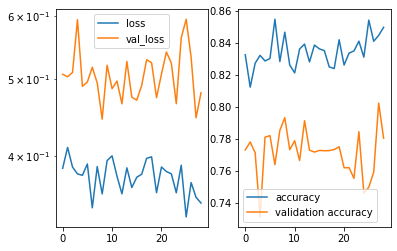

10/10 [==============================] - 2s 248ms/step - loss: 0.3485 - accuracy: 0.8497 - val_loss: 0.4800 - val_accuracy: 0.7805
Epoch 00029: early stopping


In [26]:
results = model.fit(
    train_generator,
    epochs=200,
    steps_per_epoch=10,
    validation_data=val_generator,
    callbacks=callbacks,
    validation_steps=4,
)

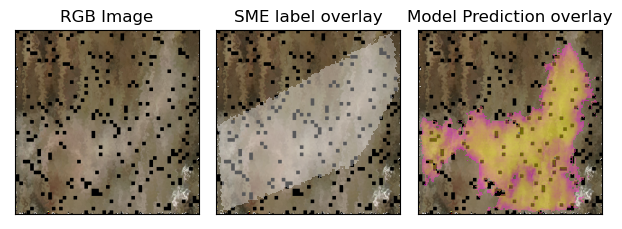

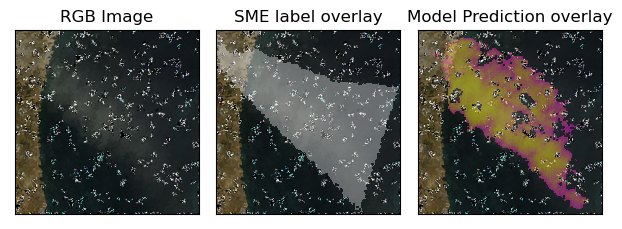

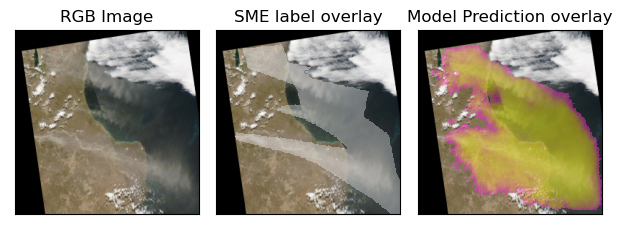

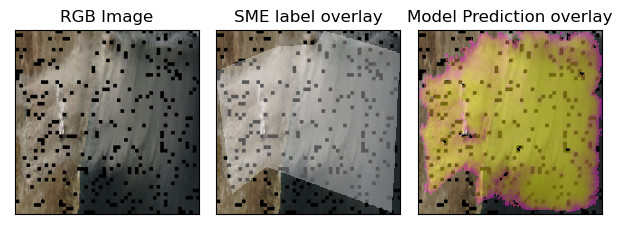

In [32]:
val_generator = UnetGenerator('pixel-level-HLD-classifier/data/val/',
    batch_size=4,
    augment=True
)
random_batch = np.random.randint(low=0, high=9)
for batch_index, batch_data in enumerate(val_generator):
    if batch_index == random_batch:
        (modis_batch, bmp_batch) = batch_data
        bmp_predict_batch = model.predict(modis_batch)
        #fig, axes = plt.subplots()
        for j in range(len(modis_batch)):
            f, ax = plt.subplots(1, 3, constrained_layout=True, dpi=100)
            ax[0].imshow(modis_batch[j].astype('uint8'))
            ax[0].set_title('RGB Image')
            ax[0].xaxis.set_ticks([])
            ax[0].yaxis.set_ticks([])
            ax[1].imshow(modis_batch[j].astype('uint8'))
            ax[1].xaxis.set_ticks([])
            ax[1].yaxis.set_ticks([])
            ax[1].set_title('SME label overlay')
            ax[2].imshow(modis_batch[j].astype('uint8'))
            ax[2].set_title('Model Prediction overlay')
            ax[2].xaxis.set_ticks([])
            ax[2].yaxis.set_ticks([])
            bmp_data = bmp_batch[j].astype('uint8')
            ax[1].imshow(ma.masked_where(bmp_data != 1, bmp_data)[:,:,0],alpha=0.35,cmap='Purples')
            ax[2].imshow(ma.masked_where(bmp_predict_batch[j] < 0.5, bmp_predict_batch[j])[:,:,0],alpha=0.45,cmap='spring')